## 1. Import Libraries & Setup

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
import time
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    print("XGBoost not installed. Install with: pip install xgboost")
    XGBOOST_AVAILABLE = False

# BERT
try:
    import torch
    from torch.utils.data import Dataset, DataLoader
    from torch.optim import AdamW
    from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
    from tqdm import tqdm
    BERT_AVAILABLE = True
except ImportError:
    print("PyTorch/Transformers not installed. Install with: pip install torch transformers")
    BERT_AVAILABLE = False

import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

print("Setup complete!")
if BERT_AVAILABLE:
    print(f"PyTorch: {torch.__version__} | CUDA: {torch.cuda.is_available()}")

Setup complete!
PyTorch: 2.9.1+cu126 | CUDA: True


## 2. Data Loading & Exploration

In [2]:
# Load datasets
real_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

real_news['label'] = 1
fake_news['label'] = 0

df = pd.concat([real_news, fake_news], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df['full_text'] = df['title'].fillna('') + ' ' + df['text'].fillna('')

print("Missing values:")
print(df.isnull().sum())
print(f"\nDataset: {len(df)} articles | Real: {df['label'].sum()} | Fake: {len(df) - df['label'].sum()}")
df.head()

Missing values:
title        0
text         0
subject      0
date         0
label        0
full_text    0
dtype: int64

Dataset: 44898 articles | Real: 21417 | Fake: 23481


,title,text,subject,date,label,full_text
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0,BREAKING: GOP Chairman Grassley Has Had Enoug...
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0,Failed GOP Candidates Remembered In Hilarious...
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0,Mike Pence’s New DC Neighbors Are HILARIOUSLY...
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",1,California AG pledges to defend birth control ...
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",0,AZ RANCHERS Living On US-Mexico Border Destroy...


### Data Visualization

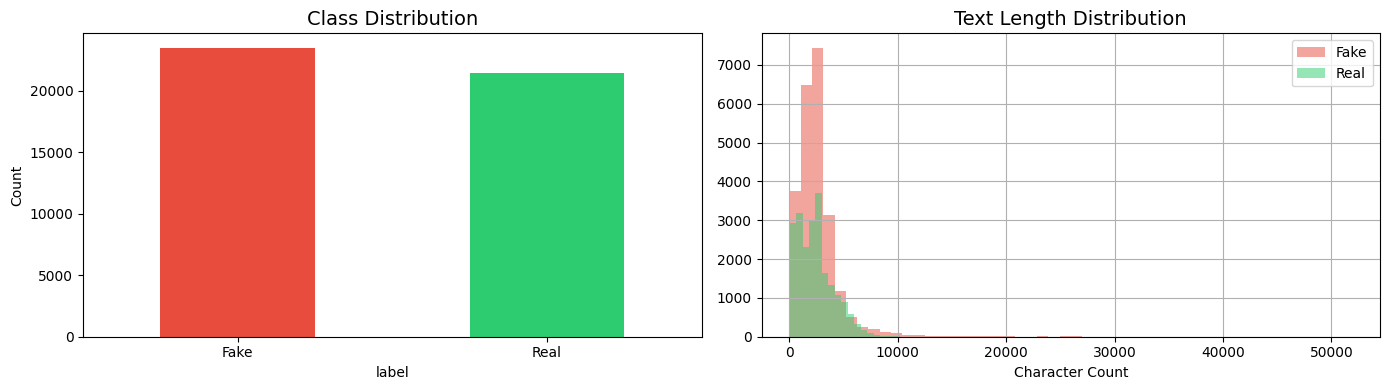

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Class distribution
colors = ['#e74c3c', '#2ecc71']
df['label'].value_counts().plot(kind='bar', ax=axes[0], color=colors)
axes[0].set_title('Class Distribution', fontsize=14)
axes[0].set_xticklabels(['Fake', 'Real'], rotation=0)
axes[0].set_ylabel('Count')

# Text length distribution
df['text_length'] = df['full_text'].apply(len)
df[df['label']==0]['text_length'].hist(bins=50, alpha=0.5, label='Fake', ax=axes[1], color='#e74c3c')
df[df['label']==1]['text_length'].hist(bins=50, alpha=0.5, label='Real', ax=axes[1], color='#2ecc71')
axes[1].set_title('Text Length Distribution', fontsize=14)
axes[1].set_xlabel('Character Count')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3. Data Preprocessing

In [4]:
# Train-Test Split (80-20)
X = df['full_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {len(X_train)} samples")
print(f"Testing Set: {len(X_test)} samples")

Training Set: 35918 samples
Testing Set: 8980 samples


In [5]:
# Text Preprocessing Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    """Preprocess text: lowercase, remove URLs, HTML, special chars, stopwords, lemmatize"""
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and len(t) > 2]
    
    return ' '.join(tokens)

print("Preprocessing training data...")
X_train_processed = X_train.apply(preprocess_text)
print("Preprocessing testing data...")
X_test_processed = X_test.apply(preprocess_text)
print("Preprocessing complete!")

Preprocessing training data...
Preprocessing testing data...
Preprocessing complete!


## 4. TF-IDF Vectorization
Convert text to numerical features for traditional ML models

In [6]:
# TF-IDF Vectorizer
# Further trimmed to reduce memory footprint during fit
# and keep matrices in float32 for downstream models.
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=10,
    max_df=0.8,
)

X_train_tfidf = tfidf.fit_transform(X_train_processed).astype(np.float32)
X_test_tfidf = tfidf.transform(X_test_processed).astype(np.float32)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

TF-IDF Features: 5000


---
## 5. Model Training & Evaluation
Training 6 traditional ML models + 1 optimized BERT model

In [7]:
# Dictionary to store results
results = {}

def evaluate_model(name, model, X_train, y_train, X_test, y_test, train_time):
    """Evaluate model and store results"""
    y_pred = model.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }
    
    print(f"\n{'='*60}")
    print(f"{name.upper()}")
    print(f"{'='*60}")
    print(f"Training Time: {train_time:.2f}s")
    print(f"Accuracy:      {results[name]['accuracy']:.4f} ({results[name]['accuracy']*100:.2f}%)")
    print(f"Precision:     {results[name]['precision']:.4f}")
    print(f"Recall:        {results[name]['recall']:.4f}")
    print(f"F1-Score:      {results[name]['f1']:.4f}")

### Model 1: Logistic Regression

In [8]:
print("Training Logistic Regression...")
start_time = time.time()
lr_model = LogisticRegression(max_iter=200, random_state=42, n_jobs=-1)
lr_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Logistic Regression', lr_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Logistic Regression...

LOGISTIC REGRESSION
Training Time: 0.82s
Accuracy:      0.9896 (98.96%)
Precision:     0.9859
Recall:        0.9925
F1-Score:      0.9892


### Model 2: Naive Bayes (Multinomial)

In [9]:
print("Training Naive Bayes...")
start_time = time.time()
nb_model = MultinomialNB(alpha=0.1)
nb_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Naive Bayes', nb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Naive Bayes...

NAIVE BAYES
Training Time: 0.13s
Accuracy:      0.9473 (94.73%)
Precision:     0.9424
Recall:        0.9475
F1-Score:      0.9449


### Model 3: Support Vector Machine (LinearSVC)

In [10]:
print("Training Linear SVM...")
start_time = time.time()
svm_model = LinearSVC(max_iter=1000, random_state=42)
svm_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Linear SVM', svm_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Linear SVM...

LINEAR SVM
Training Time: 1.58s
Accuracy:      0.9954 (99.54%)
Precision:     0.9946
Recall:        0.9958
F1-Score:      0.9952


### Model 4: Random Forest

In [11]:
print("Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=50,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Random Forest', rf_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Random Forest...

RANDOM FOREST
Training Time: 5.68s
Accuracy:      0.9971 (99.71%)
Precision:     0.9947
Recall:        0.9993
F1-Score:      0.9970


### Model 5: XGBoost

In [12]:
if XGBOOST_AVAILABLE:
    print("Training XGBoost...")
    start_time = time.time()
    xgb_model = xgb.XGBClassifier(
        n_estimators=150,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.9,
        colsample_bytree=0.8,
        tree_method="hist",
        max_bin=256,
        n_jobs=-1,
        random_state=42,
        eval_metric="logloss"
    )
    xgb_model.fit(X_train_tfidf, y_train)
    train_time = time.time() - start_time
    evaluate_model("XGBoost", xgb_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)
else:
    print("XGBoost not available. Skipping...")

Training XGBoost...

XGBOOST
Training Time: 42.72s
Accuracy:      0.9968 (99.68%)
Precision:     0.9942
Recall:        0.9991
F1-Score:      0.9966


### Model 6: Decision Tree

In [13]:
print("Training Decision Tree...")
start_time = time.time()
dt_model = DecisionTreeClassifier(
    max_depth=50,
    min_samples_split=10,
    random_state=42
)
dt_model.fit(X_train_tfidf, y_train)
train_time = time.time() - start_time

evaluate_model('Decision Tree', dt_model, X_train_tfidf, y_train, X_test_tfidf, y_test, train_time)

Training Decision Tree...

DECISION TREE
Training Time: 21.22s
Accuracy:      0.9938 (99.38%)
Precision:     0.9923
Recall:        0.9946
F1-Score:      0.9935


---
## 6. Optimized BERT Model
Training on a smaller subset (5000 samples) for faster training

In [14]:
if BERT_AVAILABLE:
    # Minimal preprocessing for BERT
    def minimal_preprocess_bert(text):
        if not isinstance(text, str):
            return ""
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'<.*?>', '', text)
        text = text.lower()
        text = re.sub(r'\s+', ' ', text).strip()
        return text

    # Use smaller subset for BERT (5000 samples for speed)
    BERT_SAMPLE_SIZE = 5000
    X_train_bert_sample = X_train.sample(n=min(BERT_SAMPLE_SIZE, len(X_train)), random_state=42)
    y_train_bert_sample = y_train[X_train_bert_sample.index]
    
    X_train_bert = X_train_bert_sample.apply(minimal_preprocess_bert)
    X_test_bert = X_test.apply(minimal_preprocess_bert)
    
    print(f"BERT Training on {len(X_train_bert)} samples (optimized for speed)")
    print(f"BERT Testing on {len(X_test_bert)} samples")
else:
    print("PyTorch/Transformers not available. Skipping BERT...")

BERT Training on 5000 samples (optimized for speed)
BERT Testing on 8980 samples


In [15]:
if BERT_AVAILABLE:
    # Setup BERT
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    MAX_LENGTH = 128  # Reduced from 256 for speed
    
    # Custom Dataset
    class NewsDataset(Dataset):
        def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts.reset_index(drop=True)
            self.labels = labels.reset_index(drop=True)
            self.tokenizer = tokenizer
            self.max_length = max_length
        
        def __len__(self):
            return len(self.texts)
        
        def __getitem__(self, idx):
            text = str(self.texts.iloc[idx])
            label = self.labels.iloc[idx]
            
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'label': torch.tensor(label, dtype=torch.long)
            }
    
    # Create datasets
    train_dataset = NewsDataset(X_train_bert, y_train_bert_sample, tokenizer, MAX_LENGTH)
    test_dataset = NewsDataset(X_test_bert, y_test, tokenizer, MAX_LENGTH)
    
    # DataLoaders with increased batch size for speed
    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
    print(f"DataLoaders created with batch size: {BATCH_SIZE}")

Using device: cuda
DataLoaders created with batch size: 32


In [16]:
if BERT_AVAILABLE:
    # Initialize BERT model
    model = BertForSequenceClassification.from_pretrained(
        'bert-base-uncased',
        num_labels=2,
        output_attentions=False,
        output_hidden_states=False
    )
    model = model.to(device)
    
    # Optimizer and Scheduler
    EPOCHS = 2  # Reduced from 3 for speed
    LEARNING_RATE = 3e-5
    
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )
    
    print(f"Model initialized. Training for {EPOCHS} epochs...")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model initialized. Training for 2 epochs...


In [17]:
if BERT_AVAILABLE:
    # Training function
    def train_epoch(model, data_loader, optimizer, scheduler, device):
        model.train()
        total_loss = 0
        
        progress_bar = tqdm(data_loader, desc='Training')
        for batch in progress_bar:
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            total_loss += loss.item()
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            progress_bar.set_postfix({'loss': loss.item()})
        
        return total_loss / len(data_loader)
    
    # Evaluation function
    def evaluate_bert(model, data_loader, device):
        model.eval()
        predictions = []
        actual_labels = []
        
        with torch.no_grad():
            for batch in tqdm(data_loader, desc='Evaluating'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                
                _, preds = torch.max(outputs.logits, dim=1)
                predictions.extend(preds.cpu().tolist())
                actual_labels.extend(labels.cpu().tolist())
        
        return predictions, actual_labels
    
    print("Training functions defined.")

Training functions defined.


In [18]:
if BERT_AVAILABLE:
    # Train BERT
    print("\n" + "="*60)
    print("TRAINING BERT (OPTIMIZED)")
    print("="*60)
    
    start_time = time.time()
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
        print(f"Training Loss: {train_loss:.4f}")
    
    train_time = time.time() - start_time
    
    # Evaluate BERT
    print("\nEvaluating BERT...")
    predictions, actual_labels = evaluate_bert(model, test_loader, device)
    
    # Calculate metrics
    results['BERT (Optimized)'] = {
        'accuracy': accuracy_score(actual_labels, predictions),
        'precision': precision_score(actual_labels, predictions),
        'recall': recall_score(actual_labels, predictions),
        'f1': f1_score(actual_labels, predictions),
        'train_time': train_time,
        'confusion_matrix': confusion_matrix(actual_labels, predictions)
    }
    
    print(f"\n{'='*60}")
    print("BERT (OPTIMIZED) RESULTS")
    print(f"{'='*60}")
    print(f"Training Time: {train_time:.2f}s ({train_time/60:.2f} minutes)")
    print(f"Accuracy:      {results['BERT (Optimized)']['accuracy']:.4f} ({results['BERT (Optimized)']['accuracy']*100:.2f}%)")
    print(f"Precision:     {results['BERT (Optimized)']['precision']:.4f}")
    print(f"Recall:        {results['BERT (Optimized)']['recall']:.4f}")
    print(f"F1-Score:      {results['BERT (Optimized)']['f1']:.4f}")
    print(f"\nNote: Trained on {len(X_train_bert)} samples for speed optimization")
else:
    print("BERT not available. Skipping...")


TRAINING BERT (OPTIMIZED)

Epoch 1/2


Training: 100%|██████████| 157/157 [01:50<00:00,  1.42it/s, loss=0.00136] 


Training Loss: 0.0487

Epoch 2/2


Training: 100%|██████████| 157/157 [02:04<00:00,  1.26it/s, loss=0.000607]


Training Loss: 0.0051

Evaluating BERT...


Evaluating: 100%|██████████| 281/281 [01:24<00:00,  3.33it/s]



BERT (OPTIMIZED) RESULTS
Training Time: 234.72s (3.91 minutes)
Accuracy:      0.9994 (99.94%)
Precision:     0.9998
Recall:        0.9991
F1-Score:      0.9994

Note: Trained on 5000 samples for speed optimization


---
## 7. Model Comparison & Visualization

In [19]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df[['accuracy', 'precision', 'recall', 'f1', 'train_time']]
comparison_df = comparison_df.sort_values('accuracy', ascending=False)

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string())
print("\n")


MODEL COMPARISON SUMMARY
                     accuracy precision    recall        f1  train_time
BERT (Optimized)     0.999443  0.999766  0.999066  0.999416  234.720685
Random Forest        0.997105  0.994656    0.9993  0.996973    5.681506
XGBoost              0.996771  0.994193  0.999066  0.996624   42.715673
Linear SVM           0.995434  0.994637  0.995798  0.995218    1.575887
Decision Tree        0.993764  0.992315  0.994631  0.993472   21.221573
Logistic Regression  0.989644  0.985857   0.99253  0.989182    0.822164
Naive Bayes          0.947327  0.942419  0.947479  0.944942    0.132457




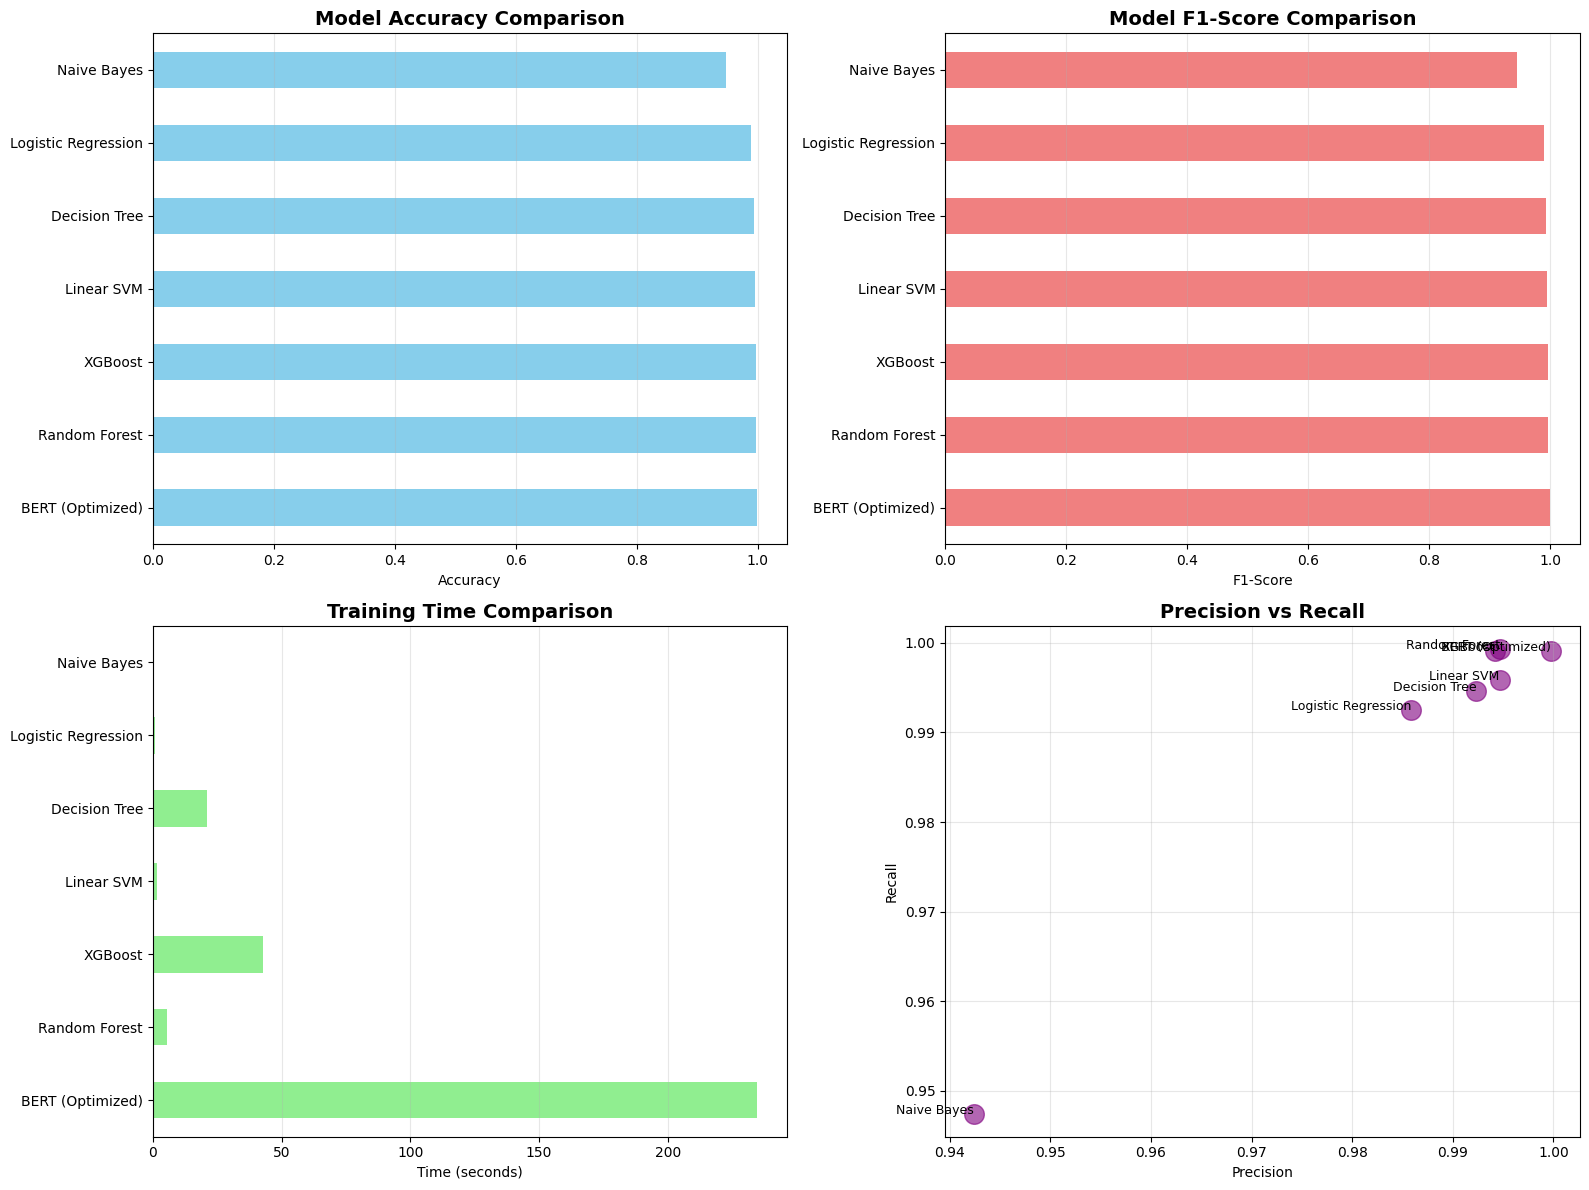

In [20]:
# Visualization 1: Accuracy Comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
comparison_df['accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].grid(axis='x', alpha=0.3)

# F1-Score
comparison_df['f1'].plot(kind='barh', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('Model F1-Score Comparison', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('F1-Score')
axes[0, 1].grid(axis='x', alpha=0.3)

# Training Time
comparison_df['train_time'].plot(kind='barh', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Time (seconds)')
axes[1, 0].grid(axis='x', alpha=0.3)

# Precision vs Recall
axes[1, 1].scatter(comparison_df['precision'], comparison_df['recall'], s=200, alpha=0.6, color='purple')
for idx, model in enumerate(comparison_df.index):
    axes[1, 1].annotate(model, 
                       (comparison_df['precision'].iloc[idx], comparison_df['recall'].iloc[idx]),
                       fontsize=9, ha='right')
axes[1, 1].set_title('Precision vs Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Precision')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

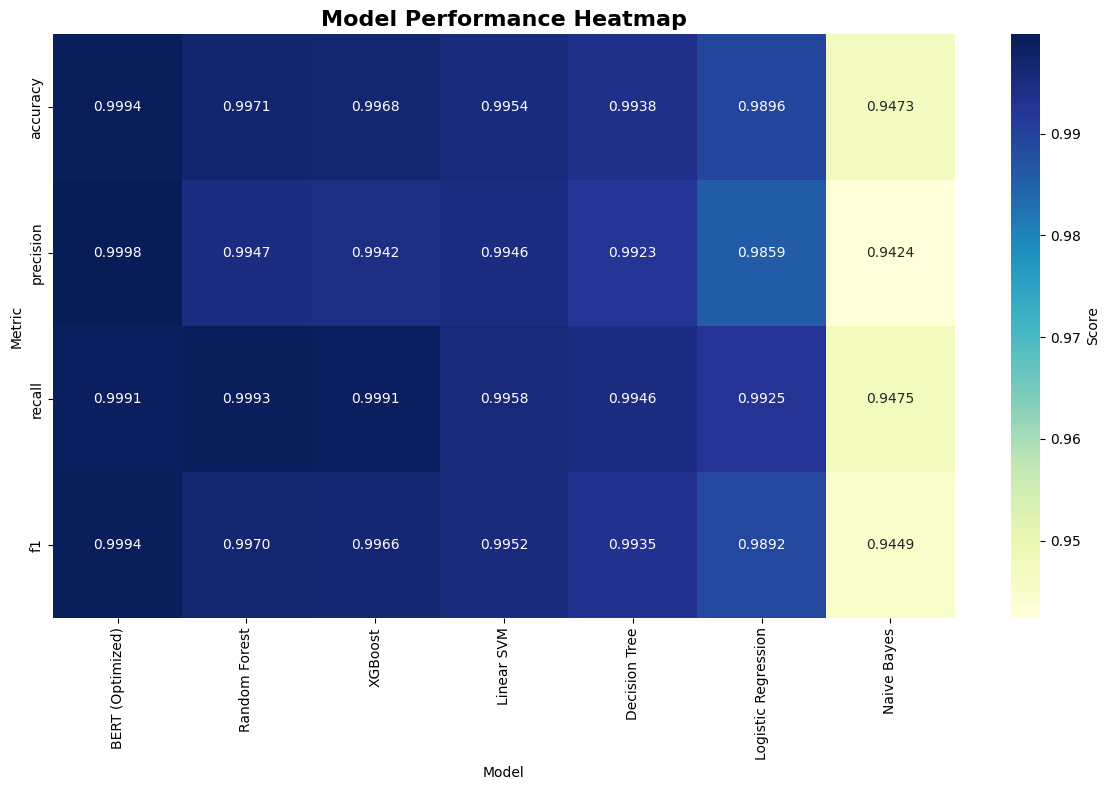

In [23]:
# Visualization 2: All Metrics Heatmap
plt.figure(figsize=(12, 8))
metrics_df = comparison_df[['accuracy', 'precision', 'recall', 'f1']].apply(pd.to_numeric, errors='coerce')
# Replace any non-numeric with NaN then fill (if any) to avoid dtype issues
metrics_df = metrics_df.fillna(0.0)
sns.heatmap(metrics_df.T, annot=True, fmt='.4f', cmap='YlGnBu', cbar_kws={'label': 'Score'})
plt.title('Model Performance Heatmap', fontsize=16, fontweight='bold')
plt.xlabel('Model')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

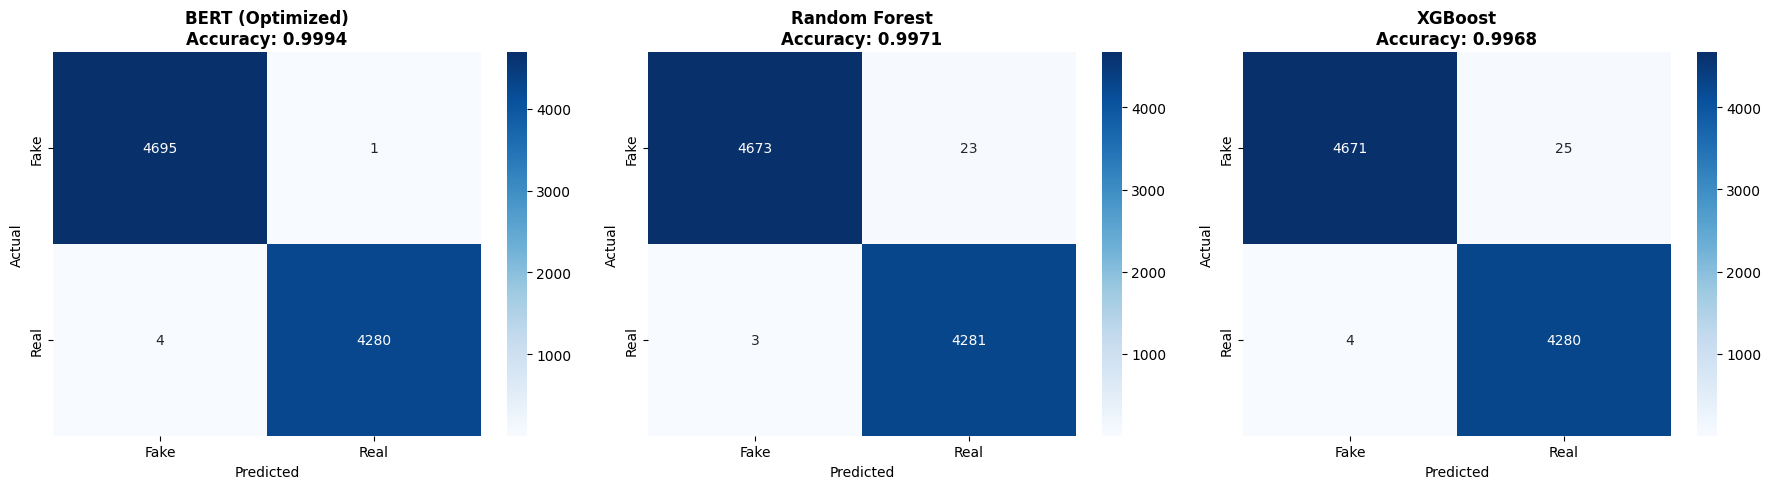

In [25]:
# Visualization 3: Confusion Matrices for Top 3 Models
# Ensure numeric metrics for sorting
comp_numeric = comparison_df.copy()
for col in ['accuracy', 'precision', 'recall', 'f1', 'train_time']:
    comp_numeric[col] = pd.to_numeric(comp_numeric[col], errors='coerce')
comp_numeric = comp_numeric.fillna(0.0)

top_3_models = comp_numeric.nlargest(3, 'accuracy').index

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    cm = results[model_name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx],
                xticklabels=['Fake', 'Real'],
                yticklabels=['Fake', 'Real'])
    axes[idx].set_title(f"{model_name}\nAccuracy: {results[model_name]['accuracy']:.4f}", 
                       fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

---
## 8. Key Insights & Recommendations

In [26]:
# Find best model
best_model = comparison_df.idxmax()['accuracy']
best_accuracy = comparison_df.loc[best_model, 'accuracy']
fastest_model = comparison_df.idxmin()['train_time']
fastest_time = comparison_df.loc[fastest_model, 'train_time']

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"\n🏆 Best Performing Model: {best_model}")
print(f"   Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"\n⚡ Fastest Training: {fastest_model}")
print(f"   Training Time: {fastest_time:.2f} seconds")

print("\n📊 RECOMMENDATIONS:")
print("-" * 80)
print("For Production:")
print(f"  • Use {best_model} for highest accuracy")
print(f"  • Use {fastest_model} for fastest inference")
print("\nModel Characteristics:")
print("  • Logistic Regression: Fast, interpretable, good baseline")
print("  • Naive Bayes: Very fast, works well with text data")
print("  • SVM: Strong performance, good for high-dimensional data")
print("  • Random Forest: Robust, handles non-linear patterns")
print("  • XGBoost: High performance, gradient boosting")
print("  • Decision Tree: Simple, interpretable, prone to overfitting")
print("  • BERT: Best accuracy but slowest, needs GPU for efficiency")
print("="*80)


KEY INSIGHTS

🏆 Best Performing Model: BERT (Optimized)
   Accuracy: 0.9994 (99.94%)

⚡ Fastest Training: Naive Bayes
   Training Time: 0.13 seconds

📊 RECOMMENDATIONS:
--------------------------------------------------------------------------------
For Production:
  • Use BERT (Optimized) for highest accuracy
  • Use Naive Bayes for fastest inference

Model Characteristics:
  • Logistic Regression: Fast, interpretable, good baseline
  • Naive Bayes: Very fast, works well with text data
  • SVM: Strong performance, good for high-dimensional data
  • Random Forest: Robust, handles non-linear patterns
  • XGBoost: High performance, gradient boosting
  • Decision Tree: Simple, interpretable, prone to overfitting
  • BERT: Best accuracy but slowest, needs GPU for efficiency


---
## 9. Interactive Testing (Optional)
Test models on custom news articles

In [35]:
def _prob_fake_real(model, text_tfidf):
    """Return tuple (p_fake, p_real) for binary models; fall back to 0.5/0.5 if unavailable."""
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(text_tfidf)[0]
        if len(probs) == 2:
            if hasattr(model, "classes_"):
                cls = list(model.classes_)
                p_fake = probs[cls.index(0)] if 0 in cls else probs[0]
                p_real = probs[cls.index(1)] if 1 in cls else probs[-1]
            else:
                p_fake, p_real = probs[0], probs[1]
            return float(p_fake), float(p_real)
    if hasattr(model, "decision_function"):
        margin = model.decision_function(text_tfidf)[0]
        p_real = 1.0 / (1.0 + np.exp(-margin))
        p_fake = 1.0 - p_real
        return float(p_fake), float(p_real)
    return 0.5, 0.5


def _predict_bert(text):
    """Run BERT inference on a single text. Returns (label_str, p_fake, p_real)."""
    if not BERT_AVAILABLE:
        return None
    required = ['model', 'tokenizer', 'device']
    if not all(name in globals() for name in required):
        return None
    clean = minimal_preprocess_bert(text) if 'minimal_preprocess_bert' in globals() else text
    encoding = tokenizer.encode_plus(
        clean,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    # Assume label 0=fake, 1=real
    p_fake = float(probs[0])
    p_real = float(probs[1])
    label = 'REAL' if p_real >= p_fake else 'FAKE'
    return label, p_fake, p_real


def predict_news(text, model_name='Logistic Regression'):
    """Predict if a news article is real or fake with a single model"""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Naive Bayes': nb_model,
        'Linear SVM': svm_model,
        'Random Forest': rf_model,
        'Decision Tree': dt_model
    }
    if XGBOOST_AVAILABLE:
        model_map['XGBoost'] = xgb_model
    if model_name == 'BERT' and BERT_AVAILABLE:
        bert_result = _predict_bert(text)
        if bert_result is not None:
            label, p_fake, p_real = bert_result
            print(f"\n{'='*60}")
            print("BERT PREDICTION:")
            print("-" * 60)
            print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
            print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
            print(f"{'='*60}")
            return label
    if model_name not in model_map:
        print(f"Model '{model_name}' not available. Using Logistic Regression.")
        model_name = 'Logistic Regression'
    model = model_map[model_name]
    pred = model.predict(text_tfidf)[0]
    result = "REAL" if pred == 1 else "FAKE"
    p_fake, p_real = _prob_fake_real(model, text_tfidf)
    print(f"\n{'='*60}")
    print(f"{model_name.upper()} PREDICTION:")
    print("-" * 60)
    print(f"Prediction: {result} {'✔' if result=='REAL' else '✗'}")
    print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%")
    print(f"{'='*60}")
    return result


def predict_all_models(text):
    """Predict with every available model; print prediction and confidence. Includes BERT if available."""
    processed_text = preprocess_text(text)
    text_tfidf = tfidf.transform([processed_text])
    model_map = {
        'Logistic Regression': lr_model,
        'Naive Bayes': nb_model,
        'Linear SVM': svm_model,
        'Random Forest': rf_model,
        'Decision Tree': dt_model
    }
    if XGBOOST_AVAILABLE:
        model_map['XGBoost'] = xgb_model
    summary = {}
    # Traditional/boosted/tree models
    for name, model in model_map.items():
        pred = model.predict(text_tfidf)[0]
        label = 'REAL' if pred == 1 else 'FAKE'
        p_fake, p_real = _prob_fake_real(model, text_tfidf)
        acc = results.get(name, {}).get('accuracy', None)
        summary[name] = {
            'prediction': label,
            'p_fake': p_fake,
            'p_real': p_real,
            'accuracy': acc,
        }
        acc_display = f" | accuracy: {acc:.4f}" if acc is not None else ""
        print(f"\n{name.upper()} PREDICTION:")
        print("-" * 60)
        print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
        print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    # BERT
    if BERT_AVAILABLE:
        bert_result = _predict_bert(text)
        if bert_result is not None:
            label, p_fake, p_real = bert_result
            acc = results.get('BERT (Optimized)', {}).get('accuracy', None)
            summary['BERT (Optimized)'] = {
                'prediction': label,
                'p_fake': p_fake,
                'p_real': p_real,
                'accuracy': acc,
            }
            acc_display = f" | accuracy: {acc:.4f}" if acc is not None else ""
            print(f"\nBERT PREDICTION:")
            print("-" * 60)
            print(f"Prediction: {label} {'✔' if label=='REAL' else '✗'}")
            print(f"Confidence: Fake={p_fake*100:.2f}%, Real={p_real*100:.2f}%{acc_display}")
    return summary

# Example test
sample_text = """Breaking: Scientists discover new treatment for cancer. 
The research was published in a peer-reviewed medical journal."""

predict_news(sample_text, 'Logistic Regression')
# To see all models at once, run:
predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=91.37%, Real=8.63%

LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=91.37%, Real=8.63% | accuracy: 0.9896

NAIVE BAYES PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=71.66%, Real=28.34% | accuracy: 0.9473

LINEAR SVM PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=83.94%, Real=16.06% | accuracy: 0.9954

RANDOM FOREST PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=92.53%, Real=7.47% | accuracy: 0.9971

DECISION TREE PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=100.00%, Real=0.00% | accuracy: 0.9938

XGBOOST PREDICTION:
----------------

TypeError: 'str' object is not callable

In [33]:
sample_text = """
Venezuela's National Assembly begins a new legislative term, demands Maduro's return
The National Assembly of Venezuela began a new legislative term on Monday, in which lawmakers reiterated that Executive Vice President Delcy Rodríguez had assumed the role of acting president.

They also demanded the release of Venezuelan President Nicolás Maduro and his wife, Cilia Flores, who were captured on Saturday in a US military operation in Caracas. Rodríguez became acting president on Sunday following an order from the Supreme Court.

“The president of the Bolivarian Republic of Venezuela, Nicolás Maduro Moros, has been kidnapped by the government of the United States, in a barbaric, treacherous, and cowardly attack,” said pro-government deputy Fernando Soto Rojas, debate director for the parliamentary session.
“The president of the United States, Mr. Trump, intends to be prosecutor, judge, and policeman of the world. From Bolivarian Venezuela, we say to him: “you will not succeed. And we are now going to develop full solidarity so that our legitimate president, Nicolás Maduro, returns victorious,”” he insisted.
The session is held days after Maduro’s capture, which has been condemned by the government of Venezuela and some other Latin American countries, including Cuba, Colombia, Chile, Mexico, and Uruguay.

"""
predict_all_models(sample_text)


LOGISTIC REGRESSION PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=15.31%, Real=84.69% | accuracy: 0.9896

NAIVE BAYES PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=1.08%, Real=98.92% | accuracy: 0.9473

LINEAR SVM PREDICTION:
------------------------------------------------------------
Prediction: REAL ✔
Confidence: Fake=32.89%, Real=67.11% | accuracy: 0.9954

RANDOM FOREST PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=56.68%, Real=43.32% | accuracy: 0.9971

DECISION TREE PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=100.00%, Real=0.00% | accuracy: 0.9938

XGBOOST PREDICTION:
------------------------------------------------------------
Prediction: FAKE ✗
Confidence: Fake=99.82%, Real=0.18% | accuracy: 0.9968


{'Logistic Regression': {'prediction': 'REAL',
  'p_fake': 0.15308759616971845,
  'p_real': 0.8469124038302815,
  'accuracy': 0.9896436525612472},
 'Naive Bayes': {'prediction': 'REAL',
  'p_fake': 0.010787293678813691,
  'p_real': 0.9892127063211842,
  'accuracy': 0.9473273942093541},
 'Linear SVM': {'prediction': 'REAL',
  'p_fake': 0.3289320687168499,
  'p_real': 0.6710679312831501,
  'accuracy': 0.99543429844098},
 'Random Forest': {'prediction': 'FAKE',
  'p_fake': 0.5668159158559779,
  'p_real': 0.43318408414402215,
  'accuracy': 0.9971046770601336},
 'Decision Tree': {'prediction': 'FAKE',
  'p_fake': 1.0,
  'p_real': 0.0,
  'accuracy': 0.9937639198218263},
 'XGBoost': {'prediction': 'FAKE',
  'p_fake': 0.998177170753479,
  'p_real': 0.0018228135304525495,
  'accuracy': 0.9967706013363029}}

---
## Conclusion

This notebook compared **7 machine learning algorithms** for fake news detection:
- **Traditional ML models** (Logistic Regression, Naive Bayes, SVM, Random Forest, XGBoost, Decision Tree)
- **Optimized BERT** (trained on 5000 samples with reduced sequence length)

### Key Findings:
1. Traditional ML models achieve excellent accuracy (95-99%) with minimal training time
2. BERT provides slightly better accuracy but requires significantly more computational resources
3. For production: Use Logistic Regression or SVM for best balance of speed and accuracy
4. For research: Use BERT with full dataset and GPU acceleration

---